## Tugas Besar 
### MK Penambangan Data 

<b>Nama<b>: Marina Irdayanti<br> 
<b>NIM<b>: 1301174319

**Kelas: IF-41-GAB03**

**Import library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Preparation**

In [ ]:
data = pd.read_csv("/content/drive/My Drive/baru/train.csv", sep="|")
data

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
...,...,...,...,...,...,...,...,...,...,...
1874,1,321,76.03,8,7,2,0.071651,0.236854,0.347826,0
1875,1,397,41.89,5,5,0,0.065491,0.105516,0.192308,1
1876,4,316,41.83,5,8,1,0.094937,0.132373,0.166667,0
1877,2,685,62.68,1,6,2,0.035036,0.091504,0.041667,0


**Missing Values**

In [ ]:
total_cells = np.product(data.shape)
total_missing = data.sum()

# percent of data that is missing
m = (total_missing/total_cells) * 100
m

trustLevel                     34.018095
totalScanTimeInSeconds       9321.532730
grandTotal                    508.644918
lineItemVoids                  54.699308
scansWithoutRegistration       49.042044
quantityModifications          25.252794
scannedLineItemsPerSecond       0.581375
valuePerSecond                  2.017457
lineItemVoidsPerPosition        7.454044
fraud                           0.553486
dtype: float64

In [ ]:
m.isnull()

trustLevel                   False
totalScanTimeInSeconds       False
grandTotal                   False
lineItemVoids                False
scansWithoutRegistration     False
quantityModifications        False
scannedLineItemsPerSecond    False
valuePerSecond               False
lineItemVoidsPerPosition     False
fraud                        False
dtype: bool

In [ ]:
print('Percent of missing "fraud" records is %.2f%%' %((data['fraud'].isnull().sum()/data.shape[0])*100))

Percent of missing "fraud" records is 0.00%


In [ ]:
data.duplicated().sum()

0

**Adding Additional Features**

In [ ]:
data['lineItemVoidsScan'] = data['lineItemVoids'] * data['scansWithoutRegistration']
data['ProductScan'] = data['grandTotal'] - data['lineItemVoids']
data['CountTimeScan'] = data['totalScanTimeInSeconds'] - data['lineItemVoids']
data['CountTimePerSecond'] = data['valuePerSecond'] - data['scannedLineItemsPerSecond']
data

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,lineItemVoidsScan,ProductScan,CountTimeScan,CountTimePerSecond
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,0,47.70,1047,0.024383
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,10,22.36,103,0.123704
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,30,59.16,1513,0.032427
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,32,84.31,1783,0.035349
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,21,78.53,427,0.126814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874,1,321,76.03,8,7,2,0.071651,0.236854,0.347826,0,56,68.03,313,0.165202
1875,1,397,41.89,5,5,0,0.065491,0.105516,0.192308,1,25,36.89,392,0.040025
1876,4,316,41.83,5,8,1,0.094937,0.132373,0.166667,0,40,36.83,311,0.037437
1877,2,685,62.68,1,6,2,0.035036,0.091504,0.041667,0,6,61.68,684,0.056467


In [ ]:
df = data[['fraud']]

In [ ]:
# hitung hasil median untuk fraud
median_fraud = df['fraud'].median()
# Gantikan di kolom fraud dari kumpulan data yang nilainya 0
df['fraud'] = df['fraud'].replace(
    to_replace=0, value=median_fraud)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
def set_fraud(row):
    if row["fraud"] >= 0 and row["fraud"] < 1:
        return "No fraud"
    else:
        return "fraud"

In [ ]:
df = df.assign(fraud_DESC=df.apply(set_fraud, axis=1))

df.head()

,fraud,fraud_DESC
0,0,No fraud
1,0,No fraud
2,0,No fraud
3,0,No fraud
4,0,No fraud


Jumlah produk yang memiliki No fraud :  1775
Jumlah produk yang memiliki fraud    :  104


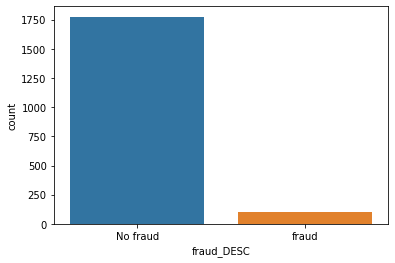

In [ ]:
import seaborn as sns
sns.countplot(data=df, x = 'fraud_DESC', label='Count')

AB, NB = df['fraud_DESC'].value_counts()
print('Jumlah produk yang memiliki No fraud : ',AB)
print('Jumlah produk yang memiliki fraud    : ',NB)

**Preprocessing**

In [ ]:
x, y = data.drop('fraud', axis=1), data['fraud']

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(x)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(data.fraud)
set(y)

{0, 1}

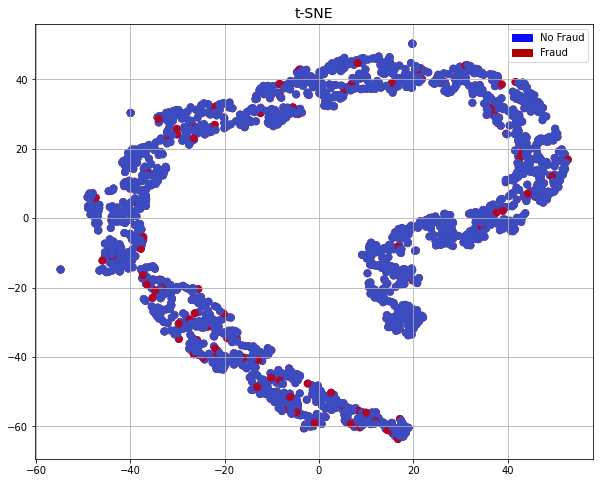

In [ ]:
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(10,8))

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

ax.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

**Classification**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE


for n in range(1, len(list(x)) + 1):
    clasiffication = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
    result_features = RFE(estimator=clasiffication, n_features_to_select=n, step=1).fit(x,y)
    print("Result features: " + str(n) + ":")
    print(x.columns[result_features.get_support()].values)
    print()

Result features: 1:
['valuePerSecond']

Result features: 2:
['trustLevel' 'valuePerSecond']

Result features: 3:
['trustLevel' 'valuePerSecond' 'lineItemVoidsPerPosition']

Result features: 4:
['trustLevel' 'valuePerSecond' 'lineItemVoidsPerPosition'
 'CountTimePerSecond']

Result features: 5:
['trustLevel' 'lineItemVoids' 'valuePerSecond' 'lineItemVoidsPerPosition'
 'CountTimePerSecond']

Result features: 6:
['trustLevel' 'lineItemVoids' 'scansWithoutRegistration' 'valuePerSecond'
 'lineItemVoidsPerPosition' 'CountTimePerSecond']

Result features: 7:
['trustLevel' 'totalScanTimeInSeconds' 'lineItemVoids'
 'scansWithoutRegistration' 'valuePerSecond' 'lineItemVoidsPerPosition'
 'CountTimePerSecond']

Result features: 8:
['trustLevel' 'totalScanTimeInSeconds' 'lineItemVoids'
 'scansWithoutRegistration' 'valuePerSecond' 'lineItemVoidsPerPosition'
 'CountTimeScan' 'CountTimePerSecond']

Result features: 9:
['trustLevel' 'totalScanTimeInSeconds' 'grandTotal' 'lineItemVoids'
 'scansWithoutRe

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = result_features.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[354   5]
 [  4  13]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       359
           1       0.72      0.76      0.74        17

    accuracy                           0.98       376
   macro avg       0.86      0.88      0.87       376
weighted avg       0.98      0.98      0.98       376



10 features:
['trustLevel' 'totalScanTimeInSeconds' 'lineItemVoids'
 'scansWithoutRegistration' 'scannedLineItemsPerSecond' 'valuePerSecond'
 'lineItemVoidsPerPosition' 'ProductScan' 'CountTimeScan'
 'CountTimePerSecond']


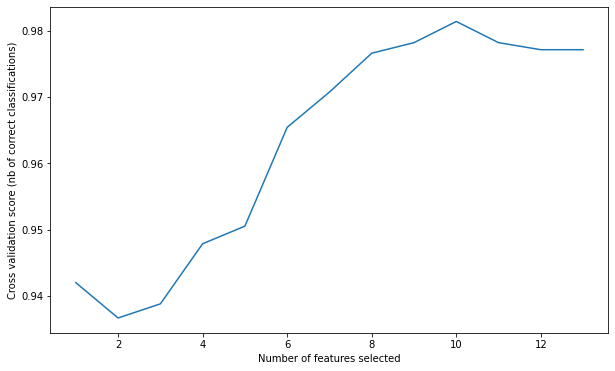

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import AdaBoostClassifier


classifier = RFECV(AdaBoostClassifier(), min_features_to_select=1, cv=10, scoring='accuracy')
classifier = classifier.fit(x,y)
print(str(classifier.n_features_) + " features:")
print(np.array(list(x))[np.array(classifier.support_)])
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(classifier.grid_scores_) + 1), classifier.grid_scores_)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[354   0]
 [  1  21]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       354
           1       1.00      0.95      0.98        22

    accuracy                           1.00       376
   macro avg       1.00      0.98      0.99       376
weighted avg       1.00      1.00      1.00       376



**Evaluation**

In [ ]:
result = classifier.estimator_

from sklearn.metrics import confusion_matrix

def This_count(cost):
        tn, fp, fn, tp = cost.ravel()
        print("TN: ", tn)
        print("FP: ", fp)
        print("FN: ", fn)
        print("TP: ", tp)
        result = (-25)*fp + (-5)*fn + 5*tp + 0*tn
        print(str(result) + " € is cost")
        print(str(result/sum(sum(cost))) + " the average result")
        return result
    
cost = confusion_matrix(y , result.predict(x.loc[:, classifier.support_]))

Value = This_count(cost)

TN:  1774
FP:  1
FN:  4
TP:  100
455 € is cost
0.24215007982969664 the average result
